In [70]:
import numpy as np
import torch
from torch import nn
import torchvision.models as models
import torchvision
from revuresnet18 import revuresnet18
import os
import cv2
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Model2p5d(torch.nn.Module):
    def __init__(self):
        super(Model2p5d, self).__init__()
        self.model = models.resnet18(pretrained = True)
         
        module_list = list()
        
        in_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        module_list.append(
            nn.Sequential(
                in_conv,
                self.model.bn1,
                self.model.relu,
                self.model.maxpool
            )
        )
                
        module_list.append(self.model.layer1)
        module_list.append(self.model.layer2)
        module_list.append(self.model.layer3)
        module_list.append(self.model.layer4)
        self.encoder = nn.ModuleList(module_list)
        
        out_planes = [3,1,1]
        layer_names = ['normal','depth','sil']
        
        self.decoders = {}
        for out_plane, layer_name in zip(out_planes, layer_names):
            module_list2 = list()
            revresnet = revuresnet18(out_planes=out_plane)
            module_list2.append(revresnet.layer1)
            module_list2.append(revresnet.layer2)
            module_list2.append(revresnet.layer3)
            module_list2.append(revresnet.layer4)
            module_list2.append(
                nn.Sequential(
                    revresnet.deconv1,
                    revresnet.bn1,
                    revresnet.relu,
                    revresnet.deconv2
                )
            )
            module_list2 = nn.ModuleList(module_list2)
            setattr(self, 'decoder_' + layer_name, module_list2)
            self.decoders[layer_name] = module_list2
        
    def forward(self,im):
        feat = im
        feat_maps = list()
        for f in self.encoder:
            feat = f(feat)
            feat_maps.append(feat)
            
        self.encoder_out = feat_maps[-1]
        
        outputs = {}
        for layer_name, decoder in self.decoders.items():
            x = feat_maps[-1]
            for idx, f in enumerate(decoder):
                x = f(x)
                if idx < len(decoder) - 1:
                    feat_map = feat_maps[-(idx + 2)]
                    assert feat_map.shape[2:4] == x.shape[2:4]
                    x = torch.cat((x, feat_map), dim=1)
            outputs[layer_name] = x
        return outputs

In [ ]:
# # Preprocess image code

# import os
# import cv2
# superpath = "/home/ghostvortex/Documents/DL_Project/Dataset/"
# for folder in sorted(os.listdir(superpath))[1:]:
#     for folder_in in sorted(os.listdir(superpath+folder)):
#         for files in sorted(os.listdir(superpath+folder+"/"+folder_in)):
#             img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
#             img = cv2.resize(img, (256,256))
#             cv2.imwrite(superpath+folder+"/"+folder_in+"/"+files, img)
            
            
# superpath = "/home/ghostvortex/Dataset/Dataset/"
# index = -1
# batch_size = 500
# for folder in sorted(os.listdir(superpath))[index+1:(index+int(batch_size/20)+1)]:
#     for folder_in in sorted(os.listdir(superpath+folder)):
#         for files in sorted(os.listdir(superpath+folder+"/"+folder_in)):
#             print(superpath+folder+"/"+folder_in+"/"+files)
#     break

In [3]:
def loader(index, batch_size):
    superpath = "/home/ghostvortex/Dataset/Dataset/"
    input_img = []
    normal_img = []
    depth_img = []
    sil_img = []
    for folder in sorted(os.listdir(superpath))[index+1:(index+int(batch_size/20)+1)]:
        for folder_in in sorted(os.listdir(superpath+folder)):
            for files in sorted(os.listdir(superpath+folder+"/"+folder_in)):
                if "rgb" in files:
                    img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                    transform = torchvision.transforms.ToTensor()
                    img = transform(img).unsqueeze(0)
                    input_img.append(img)
                elif "depth" in files:
                    img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                    transform = torchvision.transforms.ToTensor()
                    img = transform(img[:,:,0]).unsqueeze(0)
                    depth_img.append(img)
                elif "normal" in files:
                    img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                    transform = torchvision.transforms.ToTensor()
                    img = transform(img).unsqueeze(0)
                    normal_img.append(img)
                elif "sil" in files:
                    img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                    transform = torchvision.transforms.ToTensor()
                    img = transform(img[:,:,0]).unsqueeze(0)
                    sil_img.append(img)
    input_img1 = torch.cat(input_img, dim=0)
    normal_img1 = torch.cat(normal_img, dim=0)
    depth_img1 = torch.cat(depth_img, dim=0)
    sil_img1 = torch.cat(sil_img, dim=0)
    return input_img1, normal_img1, depth_img1, sil_img1

In [5]:
f = open('/home/ghostvortex/models/status-first-module.txt','w').close()

In [19]:
weights_25d = Model2p5d()
weights_25d.load_state_dict(torch.load('models/first_module.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

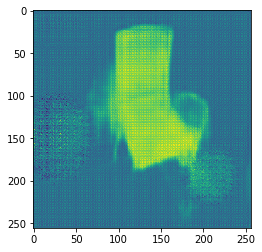

In [9]:
import matplotlib.pyplot as plt
test_img = cv2.imread('temp_ikea/sample.png')
test_img = cv2.resize(test_img, (256,256))
# plt.imshow(test_img)
transform = torchvision.transforms.ToTensor()
test_img = transform(test_img).unsqueeze(0)
output = weights_25d(test_img)
normal = output['normal'].detach().numpy().squeeze().transpose(1,2,0)
depth = output['depth'].detach().numpy().squeeze()
sil = output['sil'].detach().numpy().squeeze()
fig = plt.figure()
plt.imshow(output['normal'].detach().numpy().squeeze().transpose(1,2,0))
fig.savefig('2p5d_results/normal_'+str(count)+'.jpg')
fig = plt.figure()
plt.imshow(output['depth'].detach().numpy().squeeze())
fig.savefig('2p5d_results/depth_'+str(count)+'.jpg')
fig = plt.figure()
plt.imshow(output['sil'].detach().numpy().squeeze())
fig.savefig('2p5d_results/sil_'+str(count)+'.jpg')